In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.bandstructure import BandStructure
from pymatgen.electronic_structure.plotter import BSPlotter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Recherche des données sur The Material Project
print("Création de la structure de bande...")
with MPRester("stzwdugeNELjqCAkcHa") as mpr:
    band_struct_sl = mpr.get_bandstructure_by_material_id(material_id="mp-11327")
symm_line_dict = band_struct_sl.as_dict()
# Structure utilisée pour calculer les paramètres de bande
b_struct = BandStructure.from_dict(symm_line_dict)
# Objet utilisé pour afficher ou récupérer les données d'énergie d'un électron et vecteurs d'onde correspondant
plotter = BSPlotter(band_struct_sl)
print("Terminée")

Création de la structure de bande...
Terminée


In [3]:
# Band gap
b_g = b_struct.get_band_gap() # dict : {'direct': False, 'energy': 1.7961, 'transition': 'X-\\Gamma'}
print("La bande interdite est de", b_g['energy'], "eV")
if b_g['direct']:
    print("Le gap (direct) est visible dans le plot suivant")
else:
    print("Le gap (indirect) est visible dans le plot suivant, entre 0 et", b_g['energy'], "eV")

La bande interdite est de 1.7961 eV
Le gap (indirect) est visible dans le plot suivant, entre 0 et 1.7961 eV


Représentation de la zone de Brillouin


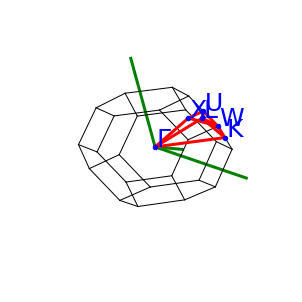

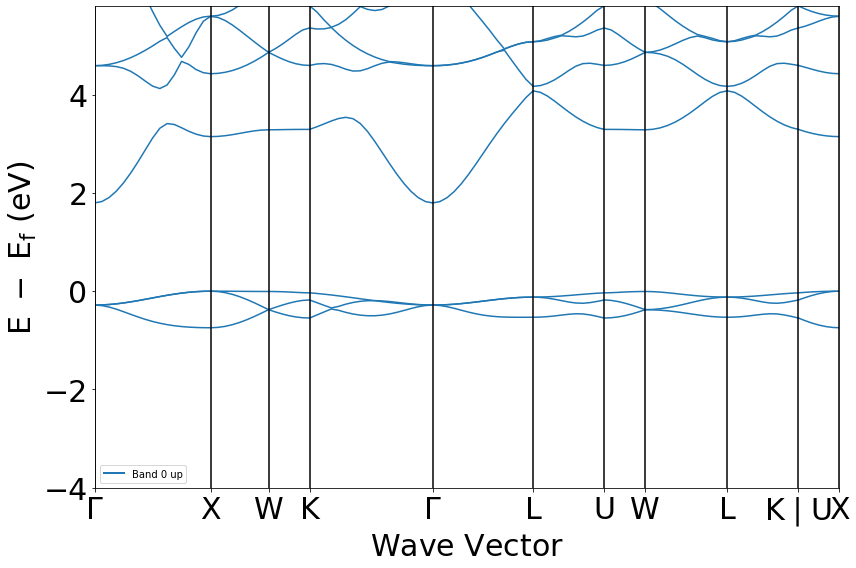

In [4]:
# Affichage de la zone de Brillouin et la structure de bande dans cette zone
print("Représentation de la zone de Brillouin")
plotter.plot_brillouin()
plotter.show()

In [6]:
# Dispersion

# La dispersion peut être déterminée en regardant la pente de l'énergie de bande 
# par rapport au vecteur d'onde k
# Nous trouvons les directions de plus grandes/plus faibles dispersion en considérant 
# la moyenne de la pente de l'énergie dans une direction donnée, soit sur un segment de la zone de Brillouin

# Données utilisées (dans ce cadre et dans le calcul de la masse effective)
data = plotter.bs_plot_data()
all_dist = data['distances']
E_bands = data['energy']['1']
# Indices des bandes de valence et de conduction
band_v = 11 # indices entre 0 et b_struct.nb_bands-1=95
band_c = 12
# Stockage des pentes recherchées
dist_in_k = np.array([])
slope_seg_v = {"min_slope" : [None, 0, 0, 0, 0], "max_slope" : [0, 0, 0, 0, 0]} # slope + start_coord (k, E) + increase (dk, dE)
slope_seg_c = {"min_slope" : [None, 0, 0, 0, 0], "max_slope" : [0, 0, 0, 0, 0]}
# Boucle sur les domaines et mise à jour des valeurs de pente
for part in range(len(all_dist)):
    k = all_dist[part]
    E_v = E_bands[part][band_v]
    E_c = E_bands[part][band_c]
    # Calcul numérique des dérivées moyennes
    i = np.arange(len(k)-1)
    dist_in_k = np.hstack((dist_in_k, k[i]))
    der1_val =  (E_v[i+1]-E_v[i])/(k[i+1]-k[i])
    der1_cond = (E_c[i+1]-E_c[i])/(k[i+1]-k[i])
    # Undate mean slope
    mean_d_v = sum(der1_val)/(len(k)-1)
    mean_d_c = sum(der1_cond)/(len(k)-1)
    if (slope_seg_v["min_slope"][0] is None or abs(slope_seg_v["min_slope"][0]) > abs(mean_d_v)):
        slope_seg_v["min_slope"] = [mean_d_v, k[0], E_v[0], k[-1]-k[0], E_v[-1]-E_v[0]]
    if (slope_seg_c["min_slope"][0] is None or abs(slope_seg_c["min_slope"][0]) > abs(mean_d_c)):
        slope_seg_c["min_slope"] = [mean_d_c, k[0], E_c[0], k[-1]-k[0], E_c[-1]-E_c[0]]
    if abs(slope_seg_v["max_slope"][0]) < abs(mean_d_v):
        slope_seg_v["max_slope"] = [mean_d_v, k[0], E_v[0], k[-1]-k[0], E_v[-1]-E_v[0]]
    if abs(slope_seg_c["max_slope"][0]) < abs(mean_d_c):
        slope_seg_c["max_slope"] = [mean_d_c, k[0], E_c[0], k[-1]-k[0], E_c[-1]-E_c[0]]


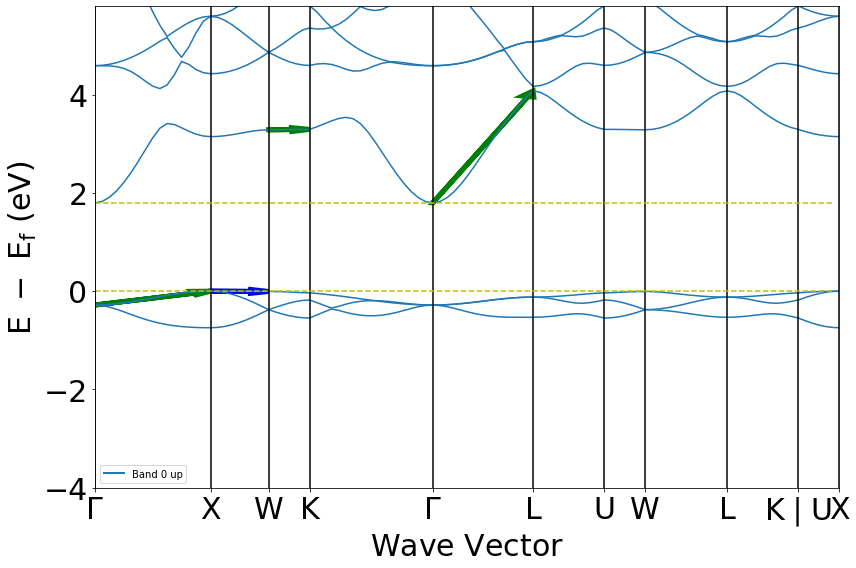

Pour la dernière bande de valence, on observe une dispersion minimale sur le segment X-W et maximale sur le segment Gamma-X
Pour la première bande de conduction, la dispersion est minimale sur le segment W-K et maximale sur le segment Gamma-L


In [12]:
# On reprend la figure précédente et on montre les directions de plus grandes pentes.
base_plot = plotter.get_plot(zero_to_efermi=True, ylim=None)
for items_list in [slope_seg_v["min_slope"], slope_seg_v["max_slope"], slope_seg_c["min_slope"], slope_seg_c["max_slope"]]:
    if items_list[0] >= 0: # pentes positives représentée en vert
        c = 'g'
    else:                 # négatives en bleu
        c = 'b'
    plt.arrow(x=items_list[1], y=items_list[2], dx=items_list[3], dy=items_list[4], color=c, linewidth=5, head_width=0.08, length_includes_head=True)

# On montre aussi le gap d'énergie, pour pouvoir mieux distinguer la position des extrema (utilisées dans la partie suivante)
plt.plot([0, dist_in_k[-1]], [0, 0], "y--")
plt.plot([0, dist_in_k[-1]], [1.7961, 1.7961], "y--")
plt.show()
print("Pour la dernière bande de valence, on observe une dispersion minimale sur le segment X-W et maximale sur le segment Gamma-X")
print("Pour la première bande de conduction, la dispersion est minimale sur le segment W-K et maximale sur le segment Gamma-L")

Calcul de la masse effective : $$\frac{1}{m^*} = \frac{d^2 E}{(dk)^2}$$

In [13]:
# La masse est calculée sur les extréma, soit lorsque la dispersion est minimale. 
# En utilisant le modèle de la masse effective vu au cours, on peut déterminer 
# la masse effective m (en unités atomiques) telle que son inverse est la dérivée seconde de la bande d'énergie
# (voir formule ci-dessus).

# Il y a 2 minima dans la première bande de conduction et 3 maxima dans la dernière bande de valence.
# Nous calculons une seule masse effective, selon une direction (dans un seul segment), pour chacun 
# (sauf le dernier en limite de domaine).
# Nous choisissons de considérer les points qui sont à droite, au plus proche de l'extrémum dans le graphe.

# Lieu des sommets/bases, leurs positions et des dérivées secondes
cond_index = [0, 4]
val_index = [1, 7, 10]
positions = ["Gamma, direction X", "X, direction W", "Gamma, direction L", "W, direction L"]
band_name = ["conduction", "valence", "conduction", "valence"]
d2Edk2 = []

for i, k_interval in enumerate(all_dist):
    for ic in cond_index:
        if i == ic:
            dk2 = (k_interval[1]-k_interval[0])*(k_interval[2]-k_interval[1])
            E_cond = E_bands[i][band_c]
            # approximation numérique
            d2Edk2.append((E_cond[0]+E_cond[2]-2*E_cond[1])/dk2)
    for iv in val_index:
        if i == iv:
            dk2 = (k_interval[1]-k_interval[0])*(k_interval[2]-k_interval[1])
            E_val = E_bands[i][band_v]
            d2Edk2.append((E_val[0]+E_val[2]-2*E_val[1])/dk2)

print("Voici les masses effectives d'un électron exprimées en unités atomiques")
for i in range(len(d2Edk2)):
    print("\tAu point", positions[i], "( bande de", band_name[i], "), la masse vaut", d2Edk2[i])

Voici les masses effectives d'un électron exprimées en unités atomiques
	Au point Gamma, direction X ( bande de conduction ), la masse vaut 22.972263958033945
	Au point X, direction W ( bande de valence ), la masse vaut -0.21389445026099804
	Au point Gamma, direction L ( bande de conduction ), la masse vaut 22.795801948400875
	Au point W, direction L ( bande de valence ), la masse vaut -2.2646070392172244
